In [1]:
include("smc_model.jl")
include("smc_model_parameters.jl")
using DifferentialEquations
using LaTeXStrings
using DataFrames
using Plots
using Measures
using DataStructures
using NLsolve
using WAV
using Dierckx 
using FFTW
using DSP
using Statistics
using JLD2, FileIO

gr()

q0 = Control_params();
p0 = Fixed_params();
s0 = State();

# Balance the ODEs at prescribed SS

Convert parameter sets to dictionaries, and delete keys that we want to solve for

In [2]:
q0_dict = type2dict(q0);
s0_dict = type2dict(s0);

delete!(q0_dict,Symbol("g_leak_mit"));
q0_dict[Symbol("k_leak_er")] = 0.0;
#q0_dict[Symbol("g_leak_ecs")] = 0.0;
delete!(q0_dict,Symbol("g_leak_ecs"));

delete!(q0_dict,Symbol("SERCA"));
#delete!(q0_dict,Symbol("Qpmca"));
q0_dict[Symbol("Qryr")]  = .2;
q0_dict[Symbol("SERCA_s")]  = 10;
q0_dict[Symbol("Qip3r")]  = 1000;
q0_dict[Symbol("MyoTot")] = 10.0;
q0_dict[Symbol("Vnclx")] = 0.128275;
q0_dict[Symbol("Qpmca")] = 0.1033/2.2;
q0_dict[Symbol("kncx2")] = 0.1248*3;
q0_dict[Symbol("Qvocc")] = 0.1947;
q0_dict[Symbol("L")] = 0.0;

delete!(s0_dict,Symbol("IP3"));
delete!(s0_dict,Symbol("IP3RX00"));
delete!(s0_dict,Symbol("IP3RX10"));
delete!(s0_dict,Symbol("IP3RX01"));
delete!(s0_dict,Symbol("RyRR10"));
delete!(s0_dict,Symbol("RyRR11"));
delete!(s0_dict,Symbol("RyRR01"));
delete!(s0_dict,Symbol("MyoMp"));
delete!(s0_dict,Symbol("MyoAM"));
delete!(s0_dict,Symbol("MyoAMp"));
delete!(s0_dict,Symbol("G"));
delete!(s0_dict,Symbol("PIP2"));
delete!(s0_dict,Symbol("Rs"));
delete!(s0_dict,Symbol("Rsp"));

excludedODEs = map(v -> Symbol(v), ["Ca_ecs","Ca_er","Ca_cyt","Phi_ecs","Ca_mit_source","Ca_ecs_source"]);
includedJs = map(v -> Symbol(v), ["er_cyt","ecs_cyt"]);
s0_balanced_dict, q0_balanced_dict = balance(s0_dict,q0_dict,excludedODEs=excludedODEs,includedJs = includedJs);

s0_balanced = reconstruct(s0,merge(s0_dict,s0_balanced_dict));
q0_balanced = reconstruct(q0,merge(q0_dict,q0_balanced_dict));

# Construct and solve elevated systems

In [196]:
Ca_mit = range(.24,.258,length=100)

function simulate_Ca_mit(Ca_mit)
    s0_elevated = reconstruct(s0_balanced, Ca_mit = Ca_mit);
    q0_elevated = reconstruct(q0_balanced, L=0.0);
    s0_elevated_dict = type2dict(s0_elevated);
    (output, problem, solution) = solveODEs(
        s0_elevated,q0_elevated,
        timespan=(0.0,60*30),
        fix = ["Ca_mit","Ca_ecs"]
        ,dtmax=100,saveat=1);
    return output
end

simulate_Ca_mit (generic function with 1 method)

In [197]:
solution_dfs = map( Ca -> simulate_Ca_mit(Ca), Ca_mit);
@save "Ca_mit_bifurcation_sims.jld2" solution_dfs
#@load "Ca_mit_bifurcation_sims.jld2" solution_dfs

In [198]:
function estimatefr(signal_o,fs;start=500)
    Ns = length(signal_o);
    if std(signal_o)!= 0.
        signal_n = (signal_o -mean(signal_o)*ones(Float16, (Ns,1)))/std(signal_o);
    else
        signal_n = (signal_o -mean(signal_o)*ones(Float16, (Ns,1)));
    end
    signal = signal_n[start:end];
    N = length(signal);
    r = periodogram(signal;nfft=N,fs=fs);
    p = r.power;
    p_sort =sortperm(abs.(p));
    freqArray = r.freq;
    freq_dom = freqArray[p_sort[end]];
    
    if freq_dom != 0
        period = 1/freq_dom;
        per_l = ceil(Int,period/fs);
    else
        per_l =  ceil(Int,N/4);
    end
    sig_p = signal_o[max(start,(end-5*per_l)):end];
 #   t_p = tti[end-2*per_l:end];
    p_max = quantile(sig_p,0.99);
    p_min = quantile(sig_p,0.01);
    #p_A = p_max-p_min;
    p_mean = mean(sig_p);

 return (freq_dom,p_max,p_min,p_mean)
    
end

function process_traces(df)
    dict = Dict()
    fs = 1;
    tti=0:1/fs: df[:t][end];
    for col in names(df)
        Ni =length(tti);
     # cyc 
        spl = Spline1D(df[:t], df[col]; k=1); 
        signal_o= spl(tti);
        dict[col] = estimatefr(signal_o,1; start = 600);
    end
    return dict
end

process_traces (generic function with 1 method)

In [199]:
processed = map(df -> process_traces(df), solution_dfs );

In [200]:
variables_to_plot = [:Ca_cyt,:Ca_er,
    :other_Ca_cyt_tot,:other_Ca_er_tot,
    :PIP2,:IP3,
    :other_Fr,:J_ecs_cyt,
    :J_er_cyt,:J_mit_cyt];

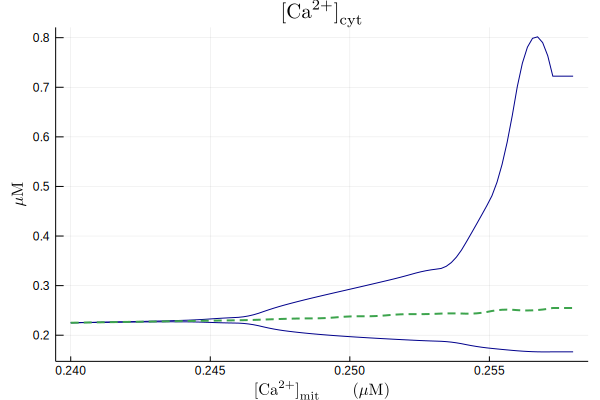

In [226]:
test = DataFrame(map(k -> map( x -> x[:Ca_cyt][k], processed), [1,2,3,4]))
#plot(Ca_mit,test[:x1])
#freq = plot(Ca_mit,test[:x1])
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_Ca_cyt = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_Ca_cyt,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"\mathrm{[Ca^{2+}]}_{\mathrm{cyt}}\qquad",ylab=L"\mu\textrm{M}")

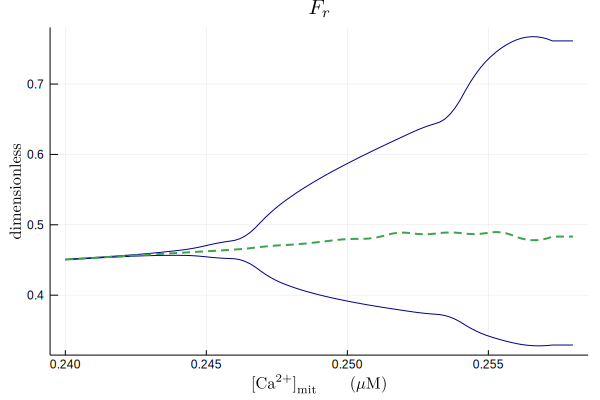

In [227]:
test = DataFrame(map(k -> map( x -> x[:other_Fr][k], processed), [1,2,3,4]))
#plot(Ca_mit,test[:x1])
#freq = plot(Ca_mit,test[:x1])
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_Fr = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_Fr,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"F_r",ylab=L"\textrm{dimensionless}")

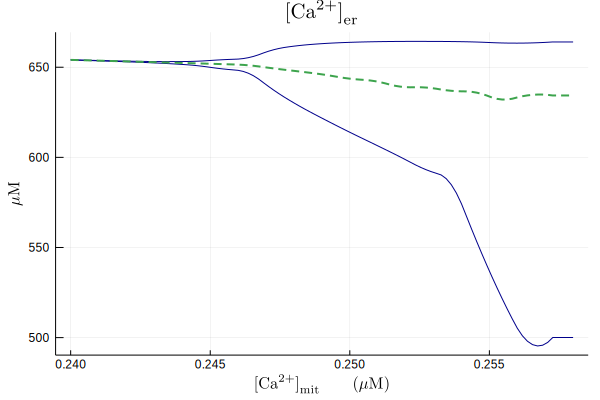

In [228]:
test = DataFrame(map(k -> map( x -> x[:Ca_er][k], processed), [1,2,3,4]))
#plot(Ca_mit,test[:x1])
#freq = plot(Ca_mit,test[:x1])
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_Ca_er = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_Ca_er,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"\mathrm{[Ca^{2+}]}_{\mathrm{er}}\qquad",ylab=L"\mu\textrm{M}")

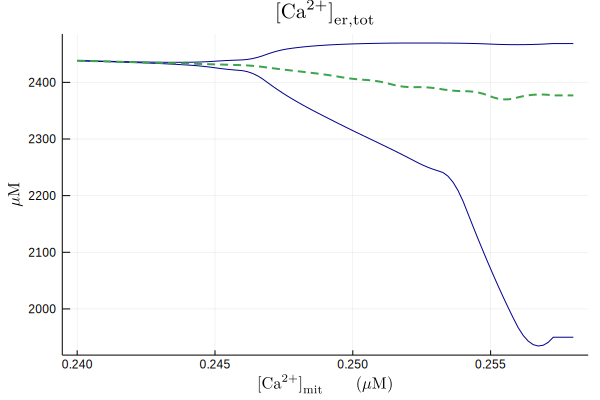

In [229]:
test = DataFrame(map(k -> map( x -> x[:other_Ca_er_tot][k], processed), [1,2,3,4]))
#plot(Ca_mit,test[:x1])
#freq = plot(Ca_mit,test[:x1])
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_Ca_er_tot = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_Ca_er_tot,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"\mathrm{[Ca^{2+}]}_{\mathrm{er,tot}}\qquad",ylab=L"\mu\textrm{M}")

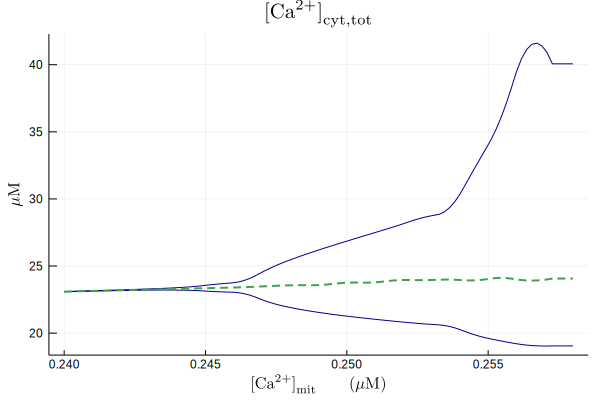

In [230]:
test = DataFrame(map(k -> map( x -> x[:other_Ca_cyt_tot][k], processed), [1,2,3,4]))
#plot(Ca_mit,test[:x1])
#freq = plot(Ca_mit,test[:x1])
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_Ca_cyt_tot = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_Ca_cyt_tot,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"\mathrm{[Ca^{2+}]}_{\mathrm{cyt,tot}}\qquad",ylab=L"\mu\textrm{M}")

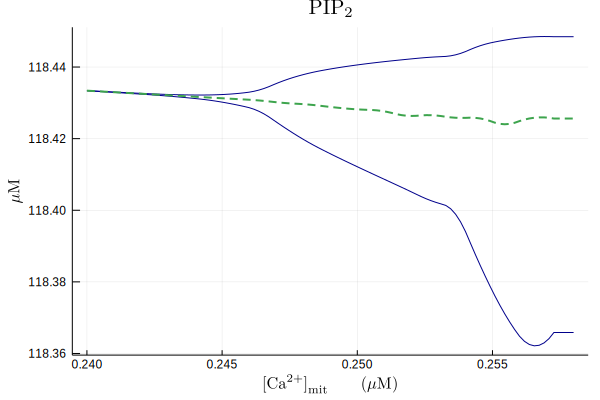

In [231]:
test = DataFrame(map(k -> map( x -> x[:PIP2][k], processed), [1,2,3,4]))
#plot(Ca_mit,test[:x1])
#freq = plot(Ca_mit,test[:x1])
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_PIP2 = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_PIP2,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"\mathrm{PIP}_2",ylab=L"\mu\textrm{M}")

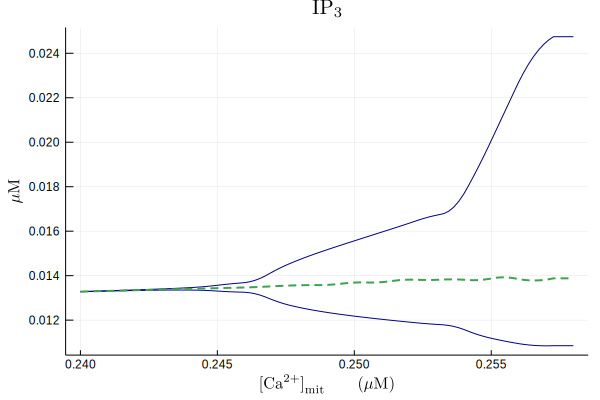

In [232]:
test = DataFrame(map(k -> map( x -> x[:IP3][k], processed), [1,2,3,4]))
#plot(Ca_mit,test[:x1])
#freq = plot(Ca_mit,test[:x1])
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_IP3 = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_IP3,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"\mathrm{IP}_3",ylab=L"\mu\textrm{M}")

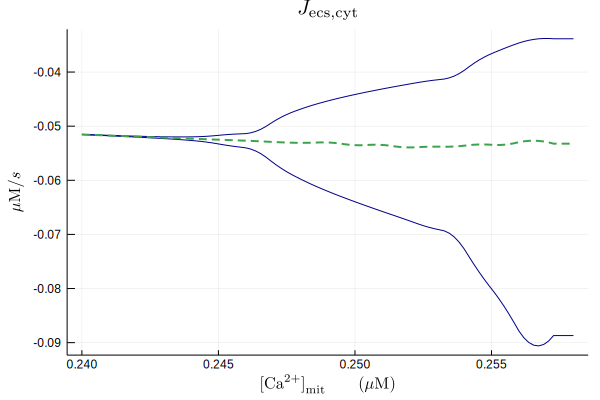

In [233]:
test = DataFrame(map(k -> map( x -> x[:J_ecs_cyt][k], processed), [1,2,3,4]))
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_J_ecs_cyt = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_J_ecs_cyt,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"J_{\mathrm{ecs,cyt}}",ylab=L"\mu\textrm{M}/s")

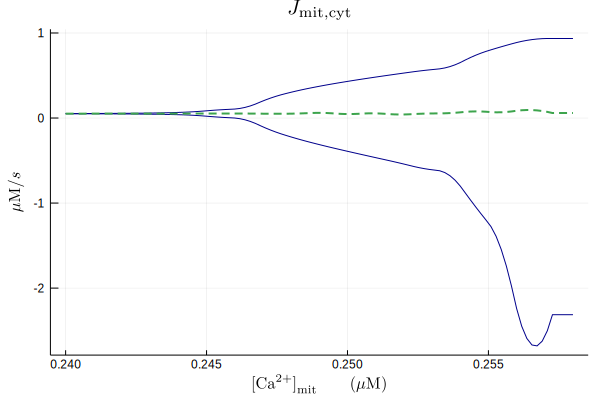

In [234]:
test = DataFrame(map(k -> map( x -> x[:J_mit_cyt][k], processed), [1,2,3,4]))
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_J_mit_cyt = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_J_mit_cyt,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"J_{\mathrm{mit,cyt}}",ylab=L"\mu\textrm{M}/s")

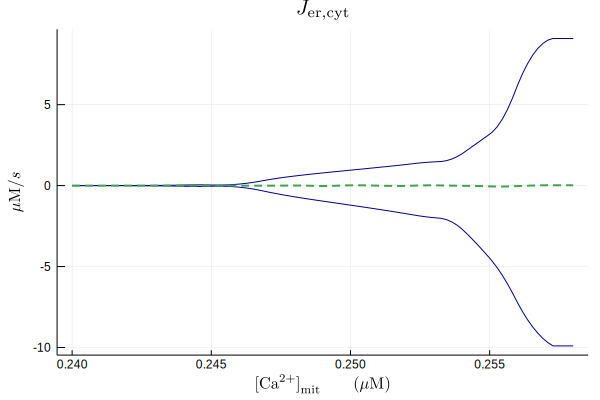

In [235]:
test = DataFrame(map(k -> map( x -> x[:J_er_cyt][k], processed), [1,2,3,4]))
spl = Spline1D(Ca_mit[1:5:end],test[:x2][1:5:end]; k=2);
hopf_J_er_cyt = plot(Ca_mit,spl(Ca_mit),color=:darkblue,legend=false)
spl = Spline1D(Ca_mit[1:5:end],test[:x3][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),color=:darkblue)
spl = Spline1D(Ca_mit[1:5:end],test[:x4][1:5:end]; k=2);
plot!(Ca_mit,spl(Ca_mit),linestyle=:dash,linewidth=2)
plot!(hopf_J_er_cyt,xlab=L"\mathrm{[Ca^{2+}]}_{\mathrm{mit}}\qquad (\mu\textrm{M})",
    title=L"J_{\mathrm{er,cyt}}",ylab=L"\mu\textrm{M}/s")

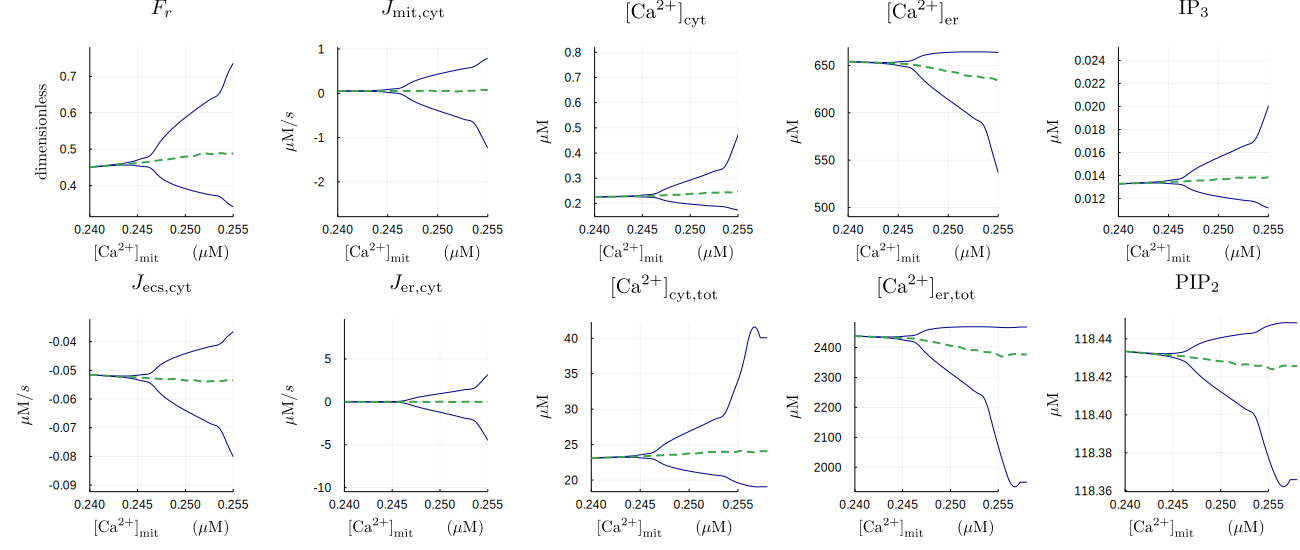

In [240]:
combined=plot(hopf_Fr,hopf_J_mit_cyt,hopf_Ca_cyt,hopf_Ca_er,hopf_IP3,
    hopf_J_ecs_cyt,hopf_J_er_cyt,hopf_Ca_cyt_tot,hopf_Ca_er_tot,hopf_PIP2,
    layout=(2,5),size=(1300,550),margin=6mm)

display(combined)
#plot!(xlim=(.24,.255))

In [241]:
savefig(combined, "hopf.png")
savefig(combined, "hopf.pdf")